# Exploring the EvalRS dataset

This notebook provides some basic EDA on the dataset of the [EvalRS](https://reclist.io/cikm2022-cup/) challenge.
Please refer to [our paper](https://arxiv.org/abs/2207.05772) for all the details.

With the goal of building a *all-around* recommender system, we likely want to understand how users, tracks and listening events are distributed, with a special case to *long tails* and rare (or new events). Yeah, you can thank us for the tip later.

Before we start, we need to clone the official repository and run a few setup steps and imports.

In [9]:
from evaluation.EvalRSRunner import ChallengeDataset

import gc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Next, we have to download the dataset (~600MB) -- actually, you'll download it just the first time!

In [10]:
dataset = ChallengeDataset()

LFM dataset already downloaded. Skipping download.
Loading dataset.


Generating Train/Test Split.
Generating dataset hashes.


And get a sample fold (see details on our Bootstrapping Cross-Validation evaluation strategy to know more about folds).

In [11]:
train, test = dataset.get_sample_train_test()
train.shape, test.shape

((6869679, 6), (29722, 3))

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6869679 entries, 0 to 37926426
Data columns (total 6 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   artist_id         int64
 2   album_id          int64
 3   track_id          int64
 4   timestamp         int64
 5   user_track_count  int64
dtypes: int64(6)
memory usage: 366.9 MB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29722 entries, 37926134 to 211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   29722 non-null  int64
 1   track_id  29722 non-null  int64
 2   fold      29722 non-null  int64
dtypes: int64(3)
memory usage: 928.8 KB


So. We have ~7M training listening records. Each tells us who (*user_id*) listened to what (*track_it*), when (*timestamp*), and how many times (*user_track_count*).

Let's now run some preprocessing to get started.

In [14]:
# convert the timestamp in a more convenient format
train["timestamp"] = pd.to_datetime(train["timestamp"], unit="s")

In [15]:
# add a column for Hour Of the Day
train["hod"] = train["timestamp"].dt.hour

In [46]:
df_exp = train[['user_id', 'track_id', 'timestamp', 'user_track_count']].sort_values('timestamp')
df_exp = pd.DataFrame(df_exp).join(dataset.df_users, on='user_id', how='left')

In [49]:
print(f"len = {len(df_exp)}")
df_exp.head()

len = 6869679


,user_id,track_id,timestamp,user_track_count,country,age,gender,playcount,registered_unixtime,country_id,...,relative_le_per_hour14,relative_le_per_hour15,relative_le_per_hour16,relative_le_per_hour17,relative_le_per_hour18,relative_le_per_hour19,relative_le_per_hour20,relative_le_per_hour21,relative_le_per_hour22,relative_le_per_hour23
37508031,2405701,1147113,2005-04-10 20:25:04,1,None,-1,None,230,1113151438,-1,...,0.0296,0.0329,0.0197,NaN,0.0428,0.0461,0.0691,0.0329,0.1283,0.0921
37508030,2405701,10722,2005-04-10 20:29:55,2,None,-1,None,230,1113151438,-1,...,0.0296,0.0329,0.0197,NaN,0.0428,0.0461,0.0691,0.0329,0.1283,0.0921
37508029,2405701,171719,2005-04-10 20:34:36,3,None,-1,None,230,1113151438,-1,...,0.0296,0.0329,0.0197,NaN,0.0428,0.0461,0.0691,0.0329,0.1283,0.0921
37508028,2405701,93031,2005-04-10 21:00:30,2,None,-1,None,230,1113151438,-1,...,0.0296,0.0329,0.0197,NaN,0.0428,0.0461,0.0691,0.0329,0.1283,0.0921
37508027,2405701,12590028,2005-04-10 21:05:11,1,None,-1,None,230,1113151438,-1,...,0.0296,0.0329,0.0197,NaN,0.0428,0.0461,0.0691,0.0329,0.1283,0.0921


In [50]:
df_exp['age'].value_counts()

age
-1     4140733
 21     271101
 22     246216
 20     240091
 23     204707
        ...   
 82        137
 89         84
 69         80
 79         69
 97         28
Name: count, Length: 102, dtype: int64

We are ready to do some EDA.

## EDA on Tracks

Let's begin with a few statistics about tracks. We can inspect how many *unique* tracks are there! 

In [16]:
percentiles = np.arange(1, step=0.1)
gb_track = train.groupby("track_id")

**Q0: what's the Track distribution?**

In [17]:
track_records = gb_track.size()
track_records.describe(percentiles)

count    228044.000000
mean         30.124358
std          41.741419
min           8.000000
0%            8.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          26.000000
80%          36.000000
90%          59.000000
max        1608.000000
dtype: float64

There are ~230K distinct tracks. But wait. We know there is a `timestamp` feature, does that mean that a user can play the same track multiple times? Programmatically, we should check if the pair <`user`,`track`> does appear multiple times.

In [18]:
len(train.groupby(["user_id", "track_id"]).size()) == train.shape[0]

True

In [19]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,hod
0,50967444,3059,114114,336613,2014-09-01 02:20:54,1,2
1,50967444,3059,114114,336156,2014-09-01 02:18:36,1,2
2,50967444,3059,114114,339139,2014-09-01 02:15:12,1,2
4,50967444,677,3035,674449,2014-09-01 00:56:28,1,0
5,50967444,677,3035,639652,2014-09-01 00:40:15,1,0


In [20]:
train['user_track_count'].value_counts()

user_track_count
1      4504994
2      1004407
3       411600
4       227725
5       144134
        ...   
554          1
923          1
706          1
517          1
403          1
Name: count, Length: 634, dtype: int64

In [21]:
train.groupby('user_id')['track_id'].nunique()

user_id
384         202
10879       218
12619       184
14308       195
15067       273
           ... 
50083088     20
50085736     30
50086315     39
50900118    161
50967444    279
Name: track_id, Length: 29722, dtype: int64

The two sizes correspond: we can assume there are no <`user`,`track`> duplicates. Indeed, the `user_track_count` value lets us know the play count!

We also obtained a new information: `track_records` contains the number of distinct users that played a given track. Let's now observe the distribution graphically.

Text(0, 0.5, 'Track Count (log)')

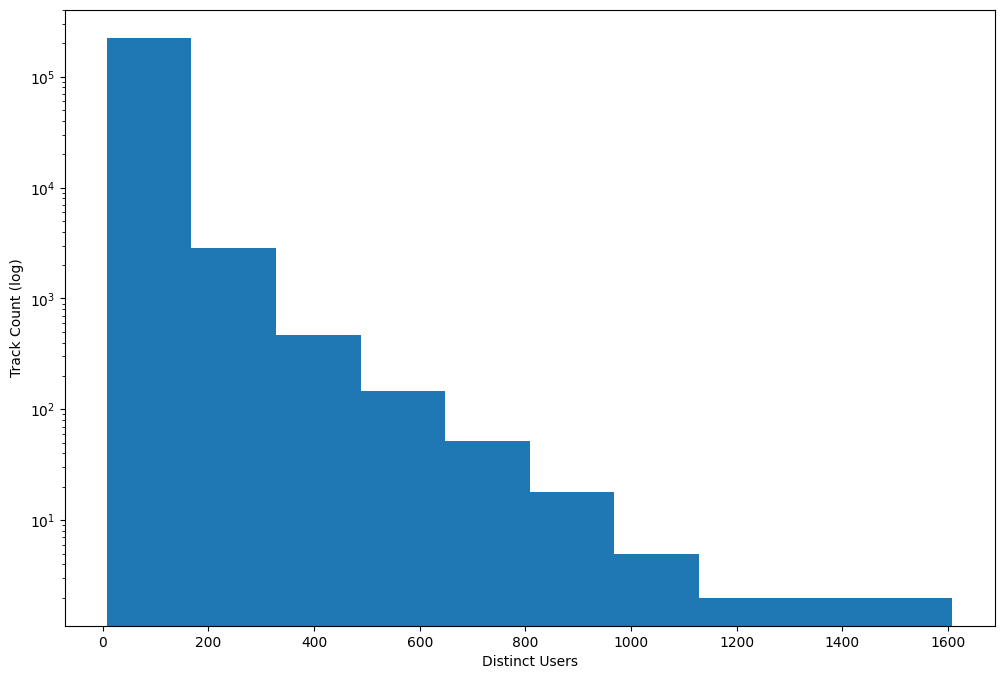

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(track_records)
ax.set_yscale("log")
ax.set_xlabel("Distinct Users")
ax.set_ylabel("Track Count (log)")

Let's look at the distribution in percentiles again. 

In [23]:
track_records.describe(percentiles)

count    228044.000000
mean         30.124358
std          41.741419
min           8.000000
0%            8.000000
10%          10.000000
20%          12.000000
30%          13.000000
40%          15.000000
50%          17.000000
60%          21.000000
70%          26.000000
80%          36.000000
90%          59.000000
max        1608.000000
dtype: float64

Tracks are listened by 30 distinct users on the average, and that 90% of them has less than 58 distinct users that played it. Further, there are some outliers: the maximum number of users is ~1600. Is this a very popular track or a dataset artifact? Let's find out.   

In [24]:
K = 10
top_by_user = track_records.iloc[track_records.argsort().values[:-(K+1):-1]]
top_by_user.name = "distinct_user_count"

# Retrieve the task information from the `dataset` handler variable
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

,track,artist_id,artist,albums_id,albums,urlSong,arousal_predicted,valence_predicted,lastfm_id,has_emotion_tags,has_social_tags,isClassic,distinct_user_count
track_id,,,,,,,,,,,,,
4868,Rolling in the Deep,504,Adele,"[1518, 18942, 64876, 66600, 80986, 93573, 9761...","['21', '19', '21 (Deluxe Edition)', 'monday_pl...",http://lyrics.wikia.com/Adele:Rolling_In_The_Deep,0.390623,-0.263898,None,None,None,True,1608
26142,We Are Young (feat. Janelle Monáe),3151,fun.,"[6907, 9619, 53139, 162664, 238945, 246098, 27...","['Some Nights', 'We Are Young', nan, 'The Best...",None,NaN,NaN,None,None,None,None,1476
11393952,Somebody That I Used to Know,3085,Gotye,"[20107, 33321, 90034, 103479, 107493, 158828, ...","['Making Mirrors (Deluxe Edition)', 'Somebody ...",http://lyrics.wikia.com/Gotye:Somebody_That_I_...,-0.383686,-0.720571,None,None,None,True,1376
16110,Get Lucky (feat. Pharrell Williams),320,Daft Punk,"[5331, 10200, 11728, 40809, 84112, 95892, 1237...","['Random Access Memories', 'Get Lucky', 'Homew...",None,NaN,NaN,None,None,None,None,1337
14034,We Found Love (feat. Calvin Harris),355,Rihanna,"[4961, 6808, 14253, 18206, 18254, 19802, 40014...","['We Found Love', 'The Official Uk Top 40 Sing...",None,NaN,NaN,None,None,None,None,1281
51176,Titanium (feat. Sia),1935,David Guetta,"[16065, 18345, 18845, 32658, 40236, 80698, 875...","['Best of...', 'Nothing but the Beat 2.0', 'No...",None,NaN,NaN,None,None,None,None,1128
572665,Set Fire to the Rain,504,Adele,"[1518, 64876, 93573, 98525, 116649, 143113, 14...","['21', '21 (Deluxe Edition)', 'Rolling in the ...",http://lyrics.wikia.com/Adele:Set_Fire_To_The_...,-0.428821,-0.415065,None,None,None,False,1086
28847,Get Lucky (Radio Edit) [feat. Pharrell Williams],320,Daft Punk,"[10200, 19277, 136209, 188202, 269754, 361728,...","['Get Lucky', nan, 'Random Access Memories', '...",None,NaN,NaN,None,None,None,None,1076
2498,Blue Jeans,402,Lana Del Rey,"[1066, 4509, 12831, 20462, 20475, 20735, 79820...","['Born to Die', 'Born to Die - The Paradise Ed...",http://lyrics.wikia.com/Lana_Del_Rey:Blue_Jeans,0.278431,-0.109800,None,None,None,False,1007


Well, these song seem pretty popular, right? But something more came up... look at position **3** and **6**: there are two different versions of *Get Lucky*. Is this something you want your model to factor in at training time? 

**Q1: How many times does a user play the same song?**

We can use the handy `user_track_count` to measure how frequently users get engaged by songs (remember to take a look at all the columns in `dataset.df_users`, there are very userful variable there).

In [25]:
avg_play_count = gb_track["user_track_count"].mean()
avg_play_count.describe(percentiles)

count    228044.000000
mean          2.552850
std           2.512765
min           1.000000
0%            1.000000
10%           1.250000
20%           1.416667
30%           1.583333
40%           1.761905
50%           1.983607
60%           2.233987
70%           2.596154
80%           3.151515
90%           4.267815
max         261.692308
Name: user_track_count, dtype: float64

On the average, a user repeats a given track ~2.6 times. Again, let's inspect our tail.

In [26]:
top_by_user = avg_play_count.iloc[avg_play_count.argsort().values[:-(K+1):-1]]
top_by_user.name = "avg_play_count"
dataset.df_tracks.loc[top_by_user.index].join(top_by_user)

,track,artist_id,artist,albums_id,albums,urlSong,arousal_predicted,valence_predicted,lastfm_id,has_emotion_tags,has_social_tags,isClassic,avg_play_count
track_id,,,,,,,,,,,,,
176516,20.000 Miles Over the Sea,48,Enigma,"[917, 60733]","['A Posteriori', 'A Posteriori (Advance)']",http://lyrics.wikia.com/Enigma:20.000_Miles_Ov...,-0.076169,-0.118055,TRXFLYS128EF3553D4,True,True,False,261.692308
361822,Bury Me in Vegas,14005,Eskimo Callboy,[125035],['Bury Me in Vegas'],http://lyrics.wikia.com/Eskimo_Callboy:Bury_Me...,0.258987,-0.205667,None,None,None,False,239.464286
2746593,Whatever,16858,4minute,"[134302, 1097460, 4794617]","['Name Is 4minute', 'Name Is 4minute', 'Name I...",None,NaN,NaN,None,None,None,None,189.600000
362676,Youth Gone Wild (Skid Row cover),8988,Asking Alexandria,"[84931, 118455, 125624]","['Life Gone Wild', 'Life Gone Wild EP', 'Life ...",None,NaN,NaN,None,None,None,None,175.133333
34135,Slow Emotion Replay,6167,The The,"[12317, 67220, 233928, 319619, 319624, 339975,...","['Dusk', 'London Town 1983-1993', '45 RPM: The...",http://lyrics.wikia.com/The_The:Slow_Emotion_R...,0.122632,-0.443743,None,None,None,False,136.947368
177,Gravity of Love,48,Enigma,"[72, 336, 1489, 10686, 60702, 195575, 195621, ...",['Love Sensuality Devotion - The Greatest Hits...,http://lyrics.wikia.com/Enigma:Gravity_Of_Love,-0.216604,0.197573,TRQSKNG128F146A48C,True,True,False,130.071429
840071,Going Nowhere Fast,18713,Joey Ramone,"[308233, 339655, 464406, 1352501]","['ya know', '...ya know?', '...ya know?', 'Ya ...",http://lyrics.wikia.com/Joey_Ramone:Going_Nowh...,0.193137,-0.180341,None,None,None,False,129.750000
993722,We Believe,59718,David Cook,"[185432, 345497, 3655166, 4282962]","['This Loud Morning (Deluxe Version)', 'This L...",http://lyrics.wikia.com/David_Cook:We_Believe,-0.025612,0.159226,None,None,None,False,127.100000
639125,Silver City,67671,Ghostland Observatory,"[229029, 400187, 1467560, 9877205]",['Live at Austin City Limits Music Festival 20...,http://lyrics.wikia.com/Ghostland_Observatory:...,0.106483,0.093438,TRVGPHZ128F424E442,True,True,False,120.882353


Here it is a new piece of information: the top 10 tracks by number of play counts is completely different than the one by number of distinct users.

In [27]:
# Cleanup..
del gb_track
del avg_play_count
del track_records
del top_by_user
_ = gc.collect()

## EDA on Users 

Let's move to users now.

In [28]:
gb_user = train.groupby("user_id")

In [29]:
user_records = gb_user.size()

In [30]:
user_records.describe(percentiles=percentiles)

count    29722.000000
mean       231.131115
std        108.109476
min          9.000000
0%           9.000000
10%         76.000000
20%        127.000000
30%        168.000000
40%        205.000000
50%        237.000000
60%        268.000000
70%        298.000000
80%        332.000000
90%        372.000000
max        496.000000
dtype: float64

plotting the age distribution

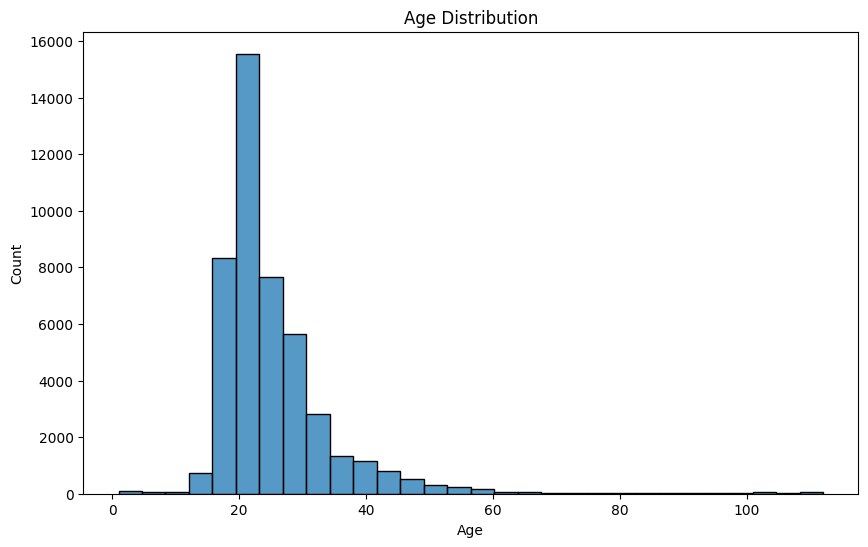

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

users = dataset.df_users

# Assuming 'users' is your DataFrame and it contains an 'age' column
# First, filter out invalid ages if necessary (e.g., ages less than 0)
valid_ages = users[users['age'] > 0]['age']

plt.figure(figsize=(10, 6))
sns.histplot(valid_ages, bins=30, kde=False)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


Based on the age distribution visible in the histogram, it seems that a significant proportion of your users are in the 20-30 age range, with fewer users as the age increases. Here’s a suggested segmentation based on typical life stages, which often correspond to different music listening preferences:

- Younger than 18 (Youth): This group is usually more into contemporary and trending music.
- 18-24 (Young Adults): College-age listeners who might have eclectic music preferences that include both contemporary hits and emerging indie artists.
- 25-34 (Early Career): Listeners who may start diversifying their music tastes with both new hits and classics.
- 35-44 (Mid-Career): This group might prefer a mix of new music and the music from their youth.
- 45-54 (Established Adults): Listeners who may value classic hits more and may not follow new music trends as closely.
- 55 and older (Seniors): This segment may have the most distinct tastes, possibly favoring older classics and less of the contemporary music.

There are almost 30K distinct users in our dataset. The average number of song they played is 232 with some binge listener that made it to 494.

What about their demographics?

In [31]:
train_users = train.join(dataset.df_users, on="user_id", rsuffix="_data")

In [44]:
dataset.df_users.head()

,country,age,gender,playcount,registered_unixtime,country_id,gender_id,novelty_artist_avg_month,novelty_artist_avg_6months,novelty_artist_avg_year,...,relative_le_per_hour14,relative_le_per_hour15,relative_le_per_hour16,relative_le_per_hour17,relative_le_per_hour18,relative_le_per_hour19,relative_le_per_hour20,relative_le_per_hour21,relative_le_per_hour22,relative_le_per_hour23
user_id,,,,,,,,,,,,,,,,,,,,,
384,UK,35,m,42139,1035849600,0,0,0.276629,0.044439,0.309429,...,0.0279,0.0410,0.0811,0.1506,0.0377,0.0298,0.0132,0.0007,0.0001,0.0151
1206,None,-1,n,33103,1035849600,-1,1,0.437224,0.109671,0.513787,...,0.0016,0.0115,0.0276,0.0662,0.0790,0.0838,0.0995,0.1195,0.0968,0.0839
2622,None,-1,None,2030,1037404800,-1,-1,0.604828,0.043923,0.698983,...,0.1320,0.0493,0.0317,0.0470,0.0658,0.1127,0.1112,0.0680,0.0437,0.0254
2732,None,-1,n,147,1037577600,-1,1,0.756973,0.020071,0.882801,...,0.0598,0.0726,0.0171,0.0342,0.0769,0.1453,0.0470,0.0513,0.0085,0.0128
3653,UK,31,m,18504,1041033600,0,0,0.380005,0.045207,0.424411,...,0.0541,0.0518,0.0564,0.0554,0.0849,0.0954,0.0833,0.0657,0.0471,0.0595


In [41]:
train_users.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,hod,country,age,gender,...,relative_le_per_hour14,relative_le_per_hour15,relative_le_per_hour16,relative_le_per_hour17,relative_le_per_hour18,relative_le_per_hour19,relative_le_per_hour20,relative_le_per_hour21,relative_le_per_hour22,relative_le_per_hour23
0,50967444,3059,114114,336613,2014-09-01 02:20:54,1,2,None,16,n,...,0.0153,0.0292,0.0422,0.0438,0.0547,0.0508,0.0428,0.046,0.0575,0.0568
1,50967444,3059,114114,336156,2014-09-01 02:18:36,1,2,None,16,n,...,0.0153,0.0292,0.0422,0.0438,0.0547,0.0508,0.0428,0.046,0.0575,0.0568
2,50967444,3059,114114,339139,2014-09-01 02:15:12,1,2,None,16,n,...,0.0153,0.0292,0.0422,0.0438,0.0547,0.0508,0.0428,0.046,0.0575,0.0568
4,50967444,677,3035,674449,2014-09-01 00:56:28,1,0,None,16,n,...,0.0153,0.0292,0.0422,0.0438,0.0547,0.0508,0.0428,0.046,0.0575,0.0568
5,50967444,677,3035,639652,2014-09-01 00:40:15,1,0,None,16,n,...,0.0153,0.0292,0.0422,0.0438,0.0547,0.0508,0.0428,0.046,0.0575,0.0568


In [32]:
gb_train_users = train_users.groupby("user_id")

In [33]:
gb_train_users.first().gender.value_counts(normalize=True, dropna=False)

gender
n       0.531088
m       0.336619
f       0.130577
None    0.001716
Name: proportion, dtype: float64

Only half of our users are annotated with (binary) gender, and there is a significant skew towards males.

In [34]:
users_by_country = gb_train_users.first().country.value_counts(normalize=True, sort=True, ascending=False, dropna=False)
users_by_country

country
None    0.536236
US      0.086939
RU      0.042662
UK      0.037817
DE      0.037582
          ...   
PS      0.000034
DJ      0.000034
FJ      0.000034
KW      0.000034
ZW      0.000034
Name: proportion, Length: 163, dtype: float64

In [35]:
top_countries = gb_train_users.first().country.value_counts(dropna=True, sort=True, ascending=False)[:10]
top_countries

country
US    2584
RU    1268
UK    1124
DE    1117
PL    1094
BR     975
FI     395
NL     367
ES     328
UA     300
Name: count, dtype: int64

Text(0, 0.5, 'Count')

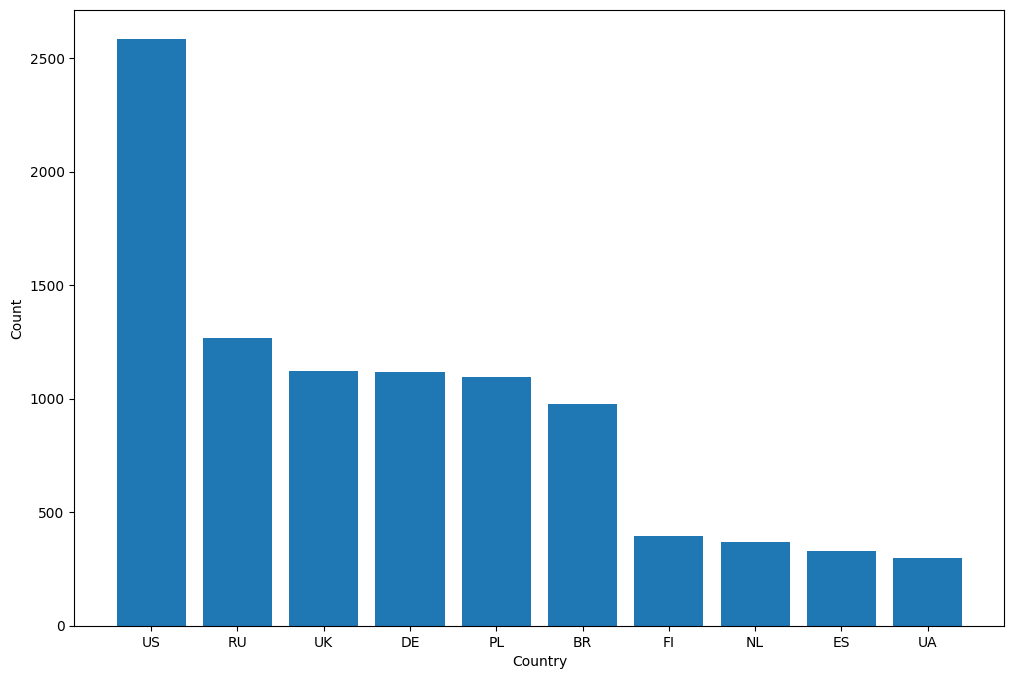

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x=top_countries.index, height=top_countries.values)
ax.set_xlabel("Country")
ax.set_ylabel("Count")

There are 158 distinct countries but only half of the users are annotated with that information. Most of the users was logged from the United States.

In [37]:
del gb_user
del gb_train_users
del top_countries
_ = gc.collect()

## Analysis on listening events

We have explored relationships between users and tracks. But what about the playing time and hour? 

For example, one might search for any correlation between listening events and hour of the day. 

**Q0: Is there any listening pattern across hours of the day?**

In [38]:
import seaborn as sns

Text(0, 0.5, 'Count')

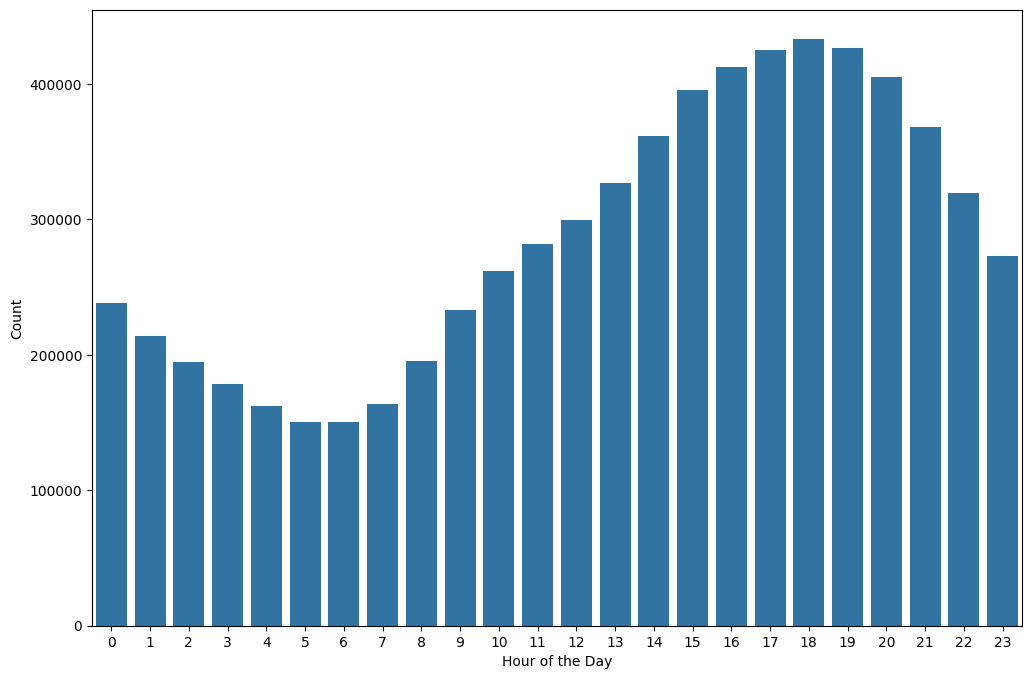

In [39]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_users, x="hod")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")

Remember that the `timestamp` attribute is in Unix time, i.e. it is absolute in terms of timezone. The chart is showing us that events are mainly located in a single timezone, as the events decrease in the morning and increase in late afternoon.   

**Q1: Is there any listening pattern across hours of the day, separately by gender?**

Text(0, 0.5, 'Count')

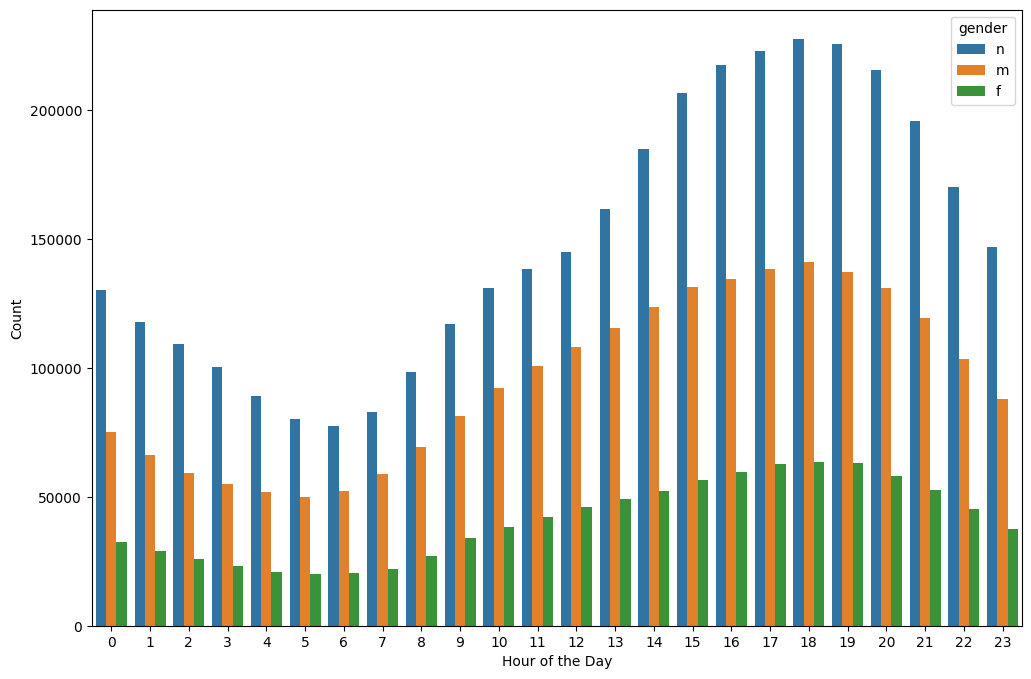

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(data=train_users, x="hod", hue="gender")
ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Count")

Judging by the chart, there seem to be no evident difference. Well, beware!